In [ ]:
import kagglehub
import os
from torch.utils.data import Dataset,DataLoader
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import requests

In [ ]:
path = kagglehub.dataset_download("mbkinaci/fruit-images-for-object-detection")

print("Path to dataset files:", path)
print("Dataset files:", os.listdir(path))

100%|██████████| 28.4M/28.4M [00:00<00:00, 102MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1
Dataset files: ['test_zip', 'train_zip']


In [ ]:
data_path = os.path.join(path, "train_zip")
print(os.listdir(data_path))

['train']


In [ ]:
train_path = os.path.join(data_path, "train")
print(os.listdir(train_path))

['banana_67.xml', 'banana_54.xml', 'apple_23.jpg', 'orange_18.jpg', 'orange_15.jpg', 'apple_28.xml', 'banana_62.xml', 'apple_31.xml', 'orange_72.jpg', 'mixed_4.jpg', 'orange_54.jpg', 'apple_35.jpg', 'apple_9.xml', 'apple_73.xml', 'orange_63.xml', 'apple_40.jpg', 'banana_71.jpg', 'apple_75.jpg', 'orange_17.jpg', 'banana_52.jpg', 'banana_69.xml', 'orange_4.jpg', 'banana_49.xml', 'banana_14.jpg', 'banana_45.xml', 'apple_59.xml', 'apple_74.jpg', 'orange_25.jpg', 'banana_3.xml', 'orange_46.jpg', 'orange_26.xml', 'orange_24.xml', 'orange_68.jpg', 'orange_17.xml', 'banana_3.jpg', 'mixed_15.xml', 'orange_22.xml', 'orange_76.xml', 'banana_72.xml', 'apple_14.jpg', 'mixed_6.xml', 'banana_44.jpg', 'apple_27.xml', 'apple_64.jpg', 'banana_52.xml', 'banana_39.xml', 'apple_7.jpg', 'orange_48.jpg', 'banana_23.xml', 'apple_4.jpg', 'banana_30.jpg', 'banana_58.xml', 'apple_21.xml', 'banana_25.jpg', 'apple_51.xml', 'apple_36.xml', 'mixed_11.jpg', 'banana_64.xml', 'mixed_17.xml', 'mixed_2.xml', 'banana_21.j

In [ ]:
# Danh sách nhãn
classes = ["apple", "banana", "orange"]

# Định nghĩa thư mục đầu vào & đầu ra
dataset_path = "/root/.cache/kagglehub/datasets/mbkinaci/fruit-images-for-object-detection/versions/1"
output_path = "dataset_yolo"

train_img_dir = os.path.join(dataset_path, "train_zip/train")
test_img_dir = os.path.join(dataset_path, "test_zip/test")

train_label_dir = os.path.join(output_path, "labels/train")
test_label_dir = os.path.join(output_path, "labels/test")

os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

def convert_voc_to_yolo(img_dir, label_dir):
    for file in os.listdir(img_dir):
        if file.endswith(".xml"):
            xml_path = os.path.join(img_dir, file)
            txt_path = os.path.join(label_dir, file.replace(".xml", ".txt"))

            tree = ET.parse(xml_path)
            root = tree.getroot()

            size = root.find("size")
            width = int(size.find("width").text) if size.find("width") is not None else 0
            height = int(size.find("height").text) if size.find("height") is not None else 0

            # Nếu width, height = 0, đọc từ ảnh
            if width == 0 or height == 0:
                img_path = os.path.join(img_dir, root.find("filename").text)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, _ = img.shape
                else:
                    print(f"Lỗi: Không thể đọc {img_path}")
                    continue

            yolo_data = []
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in classes:
                    continue
                class_id = classes.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                # Chuyển sang YOLO format
                x_center = (xmin + xmax) / (2 * width)
                y_center = (ymin + ymax) / (2 * height)
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                yolo_data.append(f"{class_id} {x_center} {y_center} {w} {h}")

            # Ghi vào file .txt
            with open(txt_path, "w") as f:
                f.write("\n".join(yolo_data))


# Chuyển đổi dữ liệu Train & Test
convert_voc_to_yolo(train_img_dir, train_label_dir)
convert_voc_to_yolo(test_img_dir, test_label_dir)

In [ ]:
import shutil

def move_images(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        if file.endswith((".jpg", ".png", ".jpeg")):  # Chỉ lấy các file ảnh
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(dst_dir, file)
            shutil.copy2(src_path, dst_path)  # Sao chép ảnh sang thư mục mới

# Thư mục ảnh gốc
train_img_src = os.path.join(dataset_path, "train_zip/train")
test_img_src = os.path.join(dataset_path, "test_zip/test")

# Thư mục ảnh đích
train_img_dst = os.path.join(output_path, "images/train")
test_img_dst = os.path.join(output_path, "images/test")

# Thực hiện di chuyển ảnh
move_images(train_img_src, train_img_dst)
move_images(test_img_src, test_img_dst)


In [ ]:
%%writefile data.yaml
train: /content/dataset_yolo/images/train
val: /content/dataset_yolo/images/test

nc: 3
names: ["apple", "banana", "orange"]


Writing data.yaml


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# Huấn luyện
model.train(data="data.yaml", epochs=50, imgsz=640, verbose=True)


Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/dataset_yolo/labels/train... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 461.55it/s]

train: WARNING ⚠️ /content/dataset_yolo/images/train/apple_62.jpg: corrupt JPEG restored and saved
train: New cache created: /content/dataset_yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset_yolo/labels/test... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 369.81it/s]

val: New cache created: /content/dataset_yolo/labels/test.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G      1.179      2.987      1.551         54        640: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         60        117    0.00634      0.966      0.373      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.53G      1.128      2.142      1.422         64        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         60        117       0.49      0.639      0.546       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.53G      1.097       1.68      1.418         68        640: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         60        117      0.621      0.501      0.601       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.53G      1.121      1.601      1.434         56        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         60        117      0.712      0.604      0.664      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.53G      1.097      1.508      1.399         97        640: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         60        117      0.684      0.574      0.612      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.53G       1.15        1.5      1.417         79        640: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         60        117      0.546      0.577      0.599      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.53G      1.057      1.377      1.353         61        640: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         60        117      0.587      0.609      0.576      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.53G       1.11      1.381      1.371         77        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         60        117      0.743      0.525      0.688      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.53G      1.099      1.333      1.372         64        640: 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         60        117      0.639      0.614      0.667      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.53G      1.055      1.281      1.372         96        640: 100%|██████████| 15/15 [00:03<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         60        117      0.569      0.634      0.662      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.53G      1.056       1.25      1.338         66        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         60        117      0.581      0.518      0.539      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.53G      1.001      1.213      1.314         65        640: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         60        117      0.679      0.697      0.692      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.53G       1.04       1.18      1.314         78        640: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         60        117      0.784      0.709      0.761      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.53G     0.9871      1.093      1.283         72        640: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         60        117      0.767      0.745      0.782      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.53G          1      1.105      1.282         80        640: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         60        117      0.776      0.801      0.832      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.53G     0.9916      1.077      1.291         55        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         60        117       0.82      0.712      0.822      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.53G     0.9831      1.059        1.3         55        640: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         60        117      0.745      0.792      0.817      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.53G     0.9584      1.032      1.256         54        640: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         60        117      0.787      0.792       0.84      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.53G     0.9254     0.9772      1.246         73        640: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         60        117      0.815      0.737      0.843      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.53G     0.9456     0.9996      1.263         63        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         60        117       0.82      0.832       0.86      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.53G     0.9308     0.9344      1.239         80        640: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         60        117      0.783      0.698      0.803      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.53G     0.9238     0.9473      1.239         71        640: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         60        117      0.754       0.78      0.808      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.53G     0.8984     0.9007      1.223         70        640: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         60        117      0.811      0.796      0.847      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.53G      0.945     0.9494      1.259         79        640: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         60        117      0.861      0.792      0.871      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.53G      0.885     0.8916      1.225         53        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         60        117      0.846      0.819      0.891      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.53G     0.8967     0.8599      1.231         65        640: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         60        117      0.894      0.772        0.9      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.53G     0.9064     0.8815      1.232         75        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         60        117      0.775       0.85      0.887      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.53G     0.8807     0.8861      1.219         68        640: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         60        117       0.84      0.845       0.92       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.53G     0.8247     0.8068      1.165         72        640: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         60        117      0.899      0.792      0.913      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.53G     0.8148     0.7794      1.158         52        640: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         60        117      0.847      0.817      0.904      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.53G     0.8537     0.7802      1.183         67        640: 100%|██████████| 15/15 [00:03<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         60        117      0.812      0.827      0.889      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.53G     0.8309      0.746      1.177         70        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         60        117      0.815      0.849      0.917      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.53G     0.8215     0.7523      1.172         72        640: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         60        117      0.863      0.821      0.915      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.53G     0.7931     0.7541      1.184         88        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         60        117      0.873       0.81      0.904      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.53G     0.8286     0.7606       1.18         74        640: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         60        117      0.907      0.783      0.899      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.53G     0.7928     0.7258      1.138         74        640: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         60        117      0.889      0.875      0.925      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.53G     0.7907     0.7235      1.153         86        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         60        117      0.874       0.85      0.918      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.53G     0.7853     0.6888      1.141         77        640: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         60        117      0.833      0.857      0.906      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.53G     0.7769     0.7153      1.157         74        640: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         60        117      0.855      0.882       0.93      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.53G     0.7434      0.667      1.122         61        640: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         60        117      0.853      0.869      0.922       0.68


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.53G      0.672     0.7857      1.126         39        640: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         60        117      0.922      0.795      0.902      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.53G     0.6522     0.7059       1.09         23        640: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         60        117        0.9      0.838      0.901      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.53G     0.6487     0.6425        1.1         39        640: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         60        117      0.908      0.872      0.926      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.53G     0.6258     0.6152        1.1         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         60        117      0.911      0.923      0.942      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.53G     0.6224     0.6105      1.062         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         60        117       0.89      0.921      0.939      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.53G     0.5999     0.6038      1.045         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         60        117      0.881      0.896      0.933      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.53G     0.5832     0.5709      1.036         46        640: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         60        117       0.89      0.877      0.921       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.53G      0.597     0.5818      1.035         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         60        117      0.873      0.853      0.915      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.53G     0.5758     0.5587      1.024         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         60        117      0.859       0.85      0.909      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.53G     0.5791     0.5597      1.047         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         60        117      0.874      0.859      0.909      0.687



50 epochs completed in 0.078 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


                   all         60        117       0.89      0.921      0.939      0.698
                 apple         24         35      0.848      0.959      0.961      0.782
                banana         22         40      0.949      0.923      0.933      0.614
                orange         22         42      0.873      0.881      0.922      0.699
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787fac1aec90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
model = YOLO("/content/runs/detect/train2/weights/best.pt")

metrics = model.val()

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset_yolo/labels/test.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


                   all         60        117      0.891      0.927      0.941      0.702
                 apple         24         35      0.844      0.971      0.961      0.788
                banana         22         40      0.949      0.924      0.935      0.623
                orange         22         42      0.882      0.886      0.925      0.694
Speed: 12.3ms preprocess, 15.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(f"Precision: {metrics.box.map50:.4f}")
print(f"Recall: {metrics.box.map:.4f}")
print(f"mAP@50: {metrics.box.map50:.4f}")
print(f"mAP@50-95: {metrics.box.map:.4f}")

Precision: 0.9406
Recall: 0.7016
mAP@50: 0.9406
mAP@50-95: 0.7016


In [ ]:
results = model.predict("https://cdnphoto.dantri.com.vn/h0rM7tgBe8coOjO4iIcIYTlWc_M=/thumb_w/1020/2019/11/04/quachuoiungthu-1572835098166.jpg", save=True, conf=0.5)  # Thay path ảnh


100%|██████████| 135k/135k [00:00<00:00, 280kB/s]

image 1/1 /content/quachuoiungthu-1572835098166.jpg: 384x640 4 bananas, 39.1ms
Speed: 2.7ms preprocess, 39.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


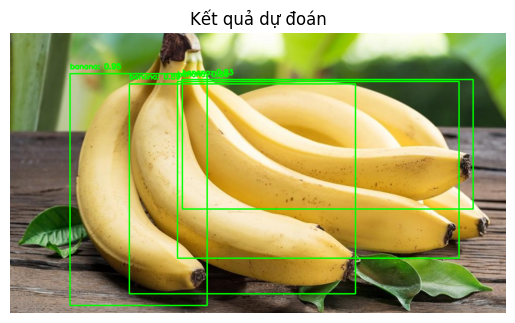

In [ ]:
url = "https://cdnphoto.dantri.com.vn/h0rM7tgBe8coOjO4iIcIYTlWc_M=/thumb_w/1020/2019/11/04/quachuoiungthu-1572835098166.jpg"
response = requests.get(url, stream=True).raw
img = np.asarray(bytearray(response.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_COLOR)

# Vẽ bounding box từ kết quả dự đoán
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Lấy tọa độ hộp
        conf = box.conf[0].item()  # Xác suất dự đoán
        cls = int(box.cls[0])  # Lớp dự đoán
        label = f"{model.names[cls]}: {conf:.2f}"

        # Vẽ hình chữ nhật quanh đối tượng
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Hiển thị ảnh kết quả
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Kết quả dự đoán")
plt.show()